# Introduction
**Chennai**, the city of multiple cultures, is the economic capital of the state of **Tamil Nadu** located in India. Known for its welcoming nature to citizens of other countries, it is no surprise that **restaurants and food outlets** play a major role. Spread across a huge land area, with beautiful **beaches**, one cannot resist visiting this place. With this project, one would know what to look for exactly, ranging from restaurants to food trucks, and enjoy as a tourist, or better *a Chennaite!*. Business People and young entrepreneurs will find this project especially helpful as it will lead to specific locations where their start-ups might become a **hit!**

The **FourSqaure API** comes handy here to access the venues in the neighbourhoods. **KMeans Clustering** is applied here to cluster venues given in the dataset. **Geopy** and **Folium** visualisation libraries are utilized here to visualise maps and come to conclusions.

## Target Audience
The target audience are the business people and young entrepreneurs who want to start their businesses in and around Chennai. The results obtained here would be useful for their endeavours. Moreover, local citizens and foodaholics can make use of these visualisations to try out new restaurants!

# Dataset Information
**Chennai** is a widely spread city with multiple areas consisting of hotels and food outlets. The link to dataset used here is: **https://chennaiiq.com/chennai/latitude_longitude_areas.asp** . The .csv file consists of columns named *Neighborhood, Latitude and Longitude*. Pre-processing steps are done here to clean the dataset. 
![image](https://user-images.githubusercontent.com/85301172/125640256-9c75afdf-0ae2-4c96-ae25-22e07dbc8b37.png)

In [ ]:
import re
import json
import requests
import numpy as np
from bs4 import BeautifulSoup

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Libraries imported.


# Data Pre-processing

After sucessfully importing all the necessary libraries, we go ahead with extracting necessary information from the html page using **soap** object and **html parser**. We collect only the location, latitude and longitude information, convert it into a dataframe, rename the columns and finally get the resulting dataframe with column names **Neighbourhood, Latitude and Longitude**. The latitude and longitude values must be converted from degrees, minutes and seconds to decimal numbers. 

In [ ]:
url = 'https://chennaiiq.com/chennai/latitude_longitude_areas.asp'
html = requests.get(url)
print(html)
soup = BeautifulSoup(html.text, "html.parser")
table = soup.find("table", attrs={"class": "TBox"})

<Response [200]>


In [ ]:
table_data = []
columns = ['Serial No.', 'Location', 'Latitude', 'Longitude']
for tr in table.find_all("tr", attrs={"class": "tab"}):
    t_row = {}
    for td, th in zip(tr.find_all("td"), columns): 
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)

chennai_data = pd.DataFrame(table_data[:-1], columns=columns)
chennai_data.drop(columns=['Serial No.'], inplace=True)
chennai_data.at[0,'Location'] = 'Adyar Bus Depot'
chennai_data.rename(columns={'Location': 'Neighbourhood'}, inplace=True)
print(chennai_data.shape)
chennai_data.head()

(105, 3)


,Neighbourhood,Latitude,Longitude
0,Adyar Bus Depot,"12°59'50"" N","80°15'25"" E"
1,Adyar Signal,"13°00'23"" N","80°15'27"" E"
2,Alandur,"13°00'28"" N","80°12'35"" E"
3,Ambattur,"13°06'36"" N","80°10'12"" E"
4,Anna Arch,"13°04'28"" N","80°13'06"" E"


In [ ]:
def convert_dms(string):
    d, m, s, direction = re.split('[°\'"]+', string)
    result = float(d)+(float(m)/60)+(float(s)/(60*60))
    if direction == 'S' or direction == 'W':
        result*=-1
    return result

chennai_data['Latitude'] = chennai_data['Latitude'].apply(convert_dms)
chennai_data['Longitude'] = chennai_data['Longitude'].apply(convert_dms)
chennai_data.head()

,Neighbourhood,Latitude,Longitude
0,Adyar Bus Depot,12.997222,80.256944
1,Adyar Signal,13.006389,80.257500
2,Alandur,13.007778,80.209722
3,Ambattur,13.110000,80.170000
4,Anna Arch,13.074444,80.218333


In [ ]:
chennai_data.shape

(105, 3)

# Methodology

## 1. Visualising Chennai
**Folium** Library is one of the most widely used library for visualisation of maps. In this step, we will find the latitude and longitude values of Chennai and visualise the areas given in the dataset. With this, we will know how **wide speard** Chennai is and what areas have the most number of **restaurants** with the help of **marker cluster algorithm**.

In [ ]:
geolocator = Nominatim(user_agent = "explore_chennai")
location = geolocator.geocode("Chennai, Tamil Nadu")
lat = location.latitude
longi = location.longitude
print("The location co-ordinates of Chennai are {} and {}.".format(lat, longi))

The location co-ordinates of Chennai are 13.0836939 and 80.270186.


In [ ]:
chennai_map = folium.Map(location = [lat, longi], zoom_start = 8)
chennai_map

In [ ]:
for lat, long, location in zip(chennai_data['Latitude'], chennai_data['Longitude'], chennai_data['Neighbourhood']):
    label = location
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [lat, long],
        popup = label
    ).add_to(chennai_map)

chennai_map

## 2. Exploring food outlets 

Here, we use our **Foursquare** credentials to extract popular restaurants in and around the areas of Chennai. We use our **Client ID and Client Secret** to access our Foursquare account and find the restaurant names. We convert all these details into a dataframe understandable by all the users. The exact **co-ordinates** of the location of the restaurants are also extracted.

In [ ]:
Client_ID = "15XVL41J2WV1LQDQHE0BXAHNCHNVHO2KQL3T11FFQJR1BM3V"
Client_Secret = "3V5QZLRT1VCA3TWBSIEAYWHIYFDAWETQVQM4JODKF2W0YNMP"
version = "20180605"

In [ ]:
def get_venues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            Client_ID, 
            Client_Secret, 
            version, 
            lat, 
            lng, 
            radius, 
            limit)
            
        iter = 1
        while iter != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                iter = 5
            except:
                iter += 1
    
  
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venues_list in venues_list for item in venues_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
chennai_venues = get_venues(names = chennai_data['Neighbourhood'],
                                 latitudes = chennai_data['Latitude'],
                                 longitudes = chennai_data['Longitude']
                                 )

print(chennai_venues.shape)
chennai_venues.head()

(1145, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Depot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Depot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Depot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Depot,12.997222,80.256944,Kovai Pazhamudir Nilayam,12.996522,80.259776,Fruit & Vegetable Store
4,Adyar Bus Depot,12.997222,80.256944,"Adyar Ananda Bhavan, Besant Nagar",12.996678,80.258275,Fast Food Restaurant


# 3. Finding unique categories

We use the **groupby** method to find the unique number of **venue categories** from the dataset that we deriver after using **Foursquare API** to get the venue category, latitude and longitude of the areas of Chennai.

In [ ]:
chennai_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
AVM Studio,4,4,4,4,4,4
Adyar Bus Depot,15,15,15,15,15,15
Adyar Signal,33,33,33,33,33,33
Alandur,12,12,12,12,12,12
Ambattur,1,1,1,1,1,1
Anna Arch,13,13,13,13,13,13
Anna Nagar Roundana,21,21,21,21,21,21
Anna Nagar West Terminus,7,7,7,7,7,7
Anna Statue,12,12,12,12,12,12


In [ ]:
unique_categories = len(chennai_venues['Venue Category'].unique())
print("The total number of unique categories of restaurants in and around Chennai is", unique_categories)

The total number of unique categories of restaurants in and around Chennai is 141


# 4. Plotting charts to check for bias

We have **150** unique venue categories. From this, we plot **bar charts** to check for bias in the dataset. If there is a bias, our methodolgy might be skewed. We will also remove venue categories that are **less than 10 in numbers**. 

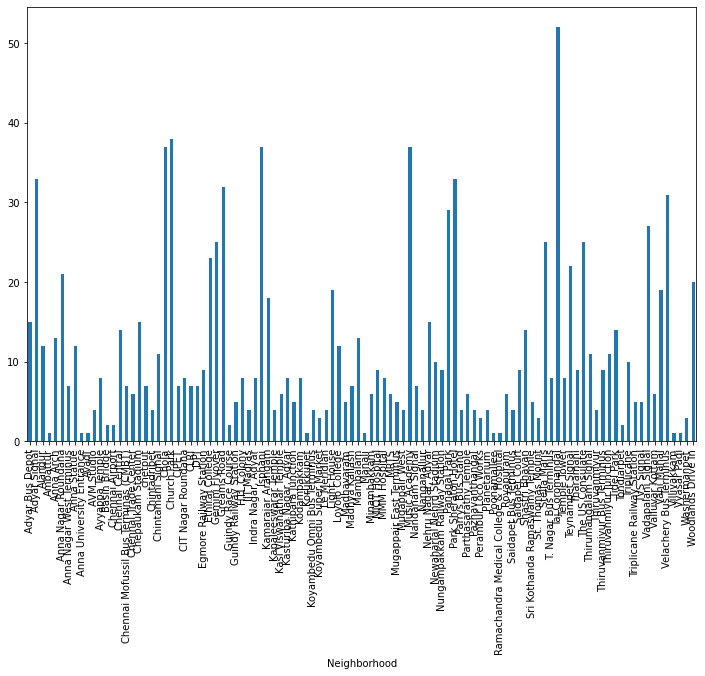

In [ ]:
temp_df = chennai_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
temp_df.plot.bar(figsize=(12, 8))

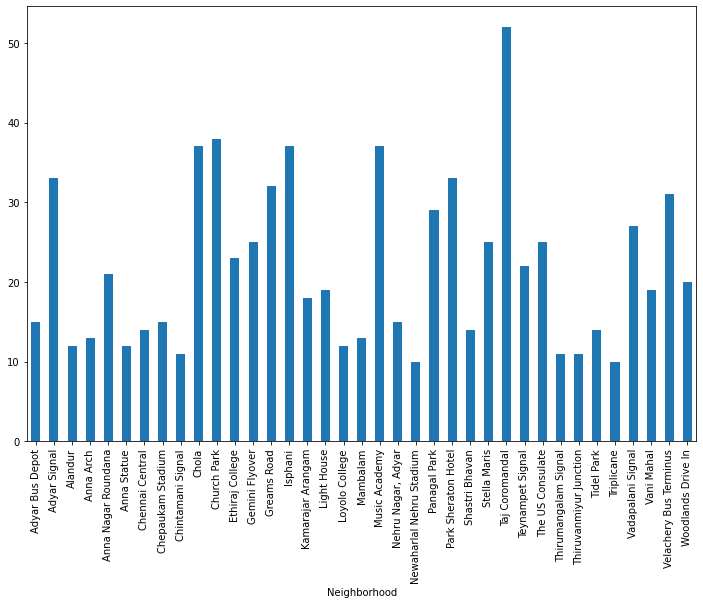

In [ ]:
temp_df = temp_df[temp_df>=10]
temp_df.plot.bar(figsize=(12, 8))

In [ ]:
top_venues = chennai_venues[chennai_venues['Neighborhood'].isin(temp_df.index.tolist())]
top_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Depot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Depot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Depot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Depot,12.997222,80.256944,Kovai Pazhamudir Nilayam,12.996522,80.259776,Fruit & Vegetable Store
4,Adyar Bus Depot,12.997222,80.256944,"Adyar Ananda Bhavan, Besant Nagar",12.996678,80.258275,Fast Food Restaurant


# 5. Executing one-hot encoding

**One-hot encoding** produces a **sparse matrix**, where most of the entires of the **m*n** matrix are **zeroes**. A column which has a value of 1 indicates that the row is associated to that column of value. This is applied to **Venue Category** as **cluster analysis** will be performed based on those categories.

In [ ]:
chennai_onehot = pd.get_dummies(top_venues['Venue Category'], prefix="", prefix_sep="")
chennai_onehot['Neighborhood'] = top_venues['Neighborhood'] 
fixed_columns = chennai_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
chennai_onehot = chennai_onehot.reindex(columns = fixed_columns)
print(chennai_onehot.shape)
chennai_onehot.head()

(805, 113)


,Neighborhood,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Bus Line,Bus Station,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,Food Truck,Fruit & Vegetable Store,Gaming Cafe,Garden,General Entertainment,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pizza Place,Platform,Pool,Pub,Ramen Restaurant,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Steakhouse,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Women's Store,Yoga Studio
0,Adyar Bus Depot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adyar Bus Depot,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adyar Bus Depot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adyar Bus Depot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adyar Bus Depot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
chennai_grouped = chennai_onehot.groupby('Neighborhood').mean().reset_index()
print(chennai_grouped.shape)
chennai_grouped.head()

(37, 113)


,Neighborhood,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Burger Joint,Bus Line,Bus Station,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Fast Food Restaurant,Flea Market,Food Court,Food Truck,Fruit & Vegetable Store,Gaming Cafe,Garden,General Entertainment,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pizza Place,Platform,Pool,Pub,Ramen Restaurant,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South American Restaurant,South Indian Restaurant,Spa,Steakhouse,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train Station,Vegetarian / Vegan Restaurant,Women's Store,Yoga Studio
0,Adyar Bus Depot,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.133333,0.0,0.066667,0.066667,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.066667,0.0,0.0,0.000000,0.000000,0.066667,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.133333,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.200000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.066667,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.066667,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,Adyar Signal,0.0,0.0,0.000000,0.0,0.0,0.030303,0.0,0.030303,0.0,0.000000,0.030303,0.0,0.000000,0.0,0.0,0.0,0.030303,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.030303,0.000000,0.0,0.000000,0.030303,0.0,0.0,0.0,0.000000,0.0,0.030303,0.0,0.0,0.060606,0.030303,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.030303,0.0,0.030303,0.0,0.000000,0.000000,0.030303,0.272727,0.030303,0.0,0.0,0.030303,0.0,0.0,0.0,0.030303,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.030303,0.0,0.000000,0.0,0.0,0.0,0.060606,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.030303,0.0,0.0,0.000000,0.000000,0.0,0.030303,0.000000,0.0,0.030303,0.0,0.0,0.030303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.0,0.0
2,Alandur,0.0,0.0,0.083333,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.083333,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.083333,0.166667,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.083333,0.083333,0.000000,0.166667,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.083333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.083333,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,Anna Arch,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.076923,0.0,0.000000,0.0,0.0,0.0,0.076923,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.076923,0.000000,0.0,0.153846,0.000000,0.0,0.0,0.0,0.076923,0.0,0.000000,0.0,0.0,0.076923,0.153846,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0000

In [ ]:
def return_top_venues(row, venues):
    rows = row.iloc[1:]
    sorted_rows = rows.sort_values(ascending=False)
    return sorted_rows.index.values[0:venues]

In [ ]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue Category'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_grouped['Neighborhood']
for ind in np.arange(chennai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_top_venues(chennai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
0,Adyar Bus Depot,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,BBQ Joint,Fruit & Vegetable Store,Middle Eastern Restaurant,Café,Breakfast Spot,Sandwich Place,Bakery
1,Adyar Signal,Indian Restaurant,Electronics Store,North Indian Restaurant,Italian Restaurant,Shoe Store,Grocery Store,Ice Cream Shop,Juice Bar,Lounge,Fast Food Restaurant
2,Alandur,Indian Restaurant,Bus Station,South Indian Restaurant,Bus Line,Restaurant,Bar,Metro Station,Hotel Bar,Airport,Hotel
3,Anna Arch,Clothing Store,Multiplex,Fast Food Restaurant,Bakery,Café,Cosmetics Shop,Electronics Store,Bookstore,Scenic Lookout,Shopping Mall
4,Anna Nagar Roundana,Indian Restaurant,Chinese Restaurant,Hotel Bar,Asian Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Electronics Store,Shoe Store,Bakery,South Indian Restaurant


# 6. Clustering neighbourhoods using K-Means clustering

**K-means clustering** algorithm is one of the most powerful techniques of **unsupervised** machine learning algorithms. With this algorithm, we can finally visualise Chennai city's map with **superimposed markers**. First, we identify the appropriate number of clusters needed for our problem at hand. For that, we use **silhouette score** from **sklearn.metrics** package. 

We will get a value of **5** which has the highest silhouette score from the graph we will plot. So, the number of clusters will be taken as 5.

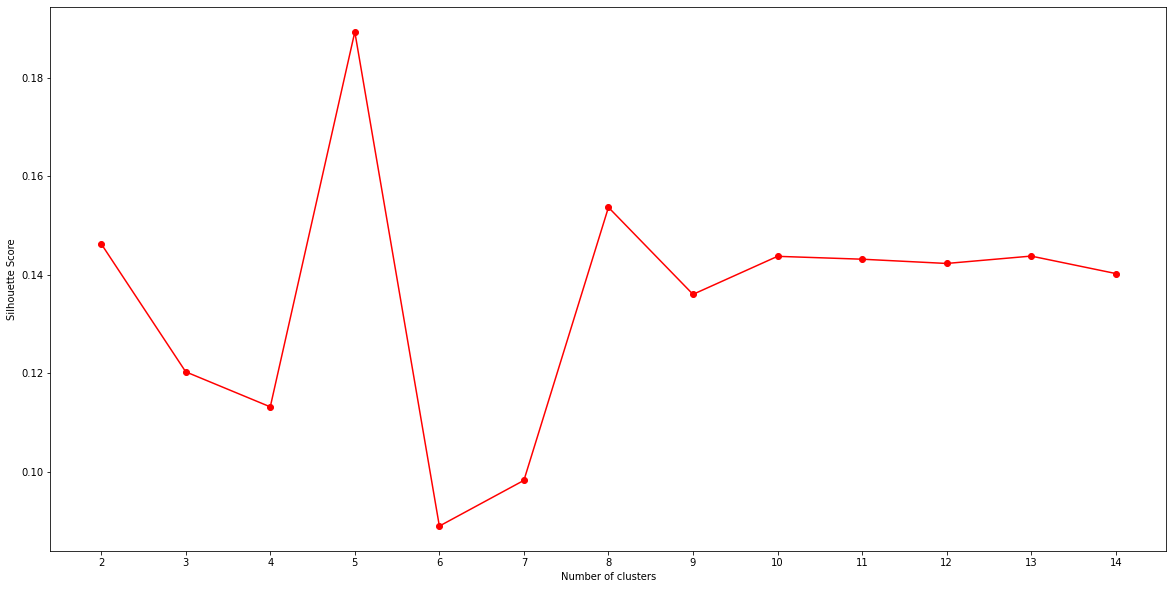

In [ ]:
chennai_grouped_clustering = chennai_grouped.drop('Neighborhood', 1)
max_score = 15
scores = []

for kclusters in range(2, max_score):
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(chennai_grouped_clustering)
    score = silhouette_score(chennai_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(chennai_grouped_clustering)
print(kmeans.labels_[0:10])
chennai_merged = top_venues[top_venues.columns[0:3]].drop_duplicates()
chennai_merged.reset_index(drop = True, inplace = True)
chennai_merged = chennai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
chennai_merged.head()

[1 1 1 2 1 0 4 0 1 1]


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
0,Adyar Bus Depot,12.997222,80.256944,1,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,BBQ Joint,Fruit & Vegetable Store,Middle Eastern Restaurant,Café,Breakfast Spot,Sandwich Place,Bakery
1,Adyar Signal,13.006389,80.257500,1,Indian Restaurant,Electronics Store,North Indian Restaurant,Italian Restaurant,Shoe Store,Grocery Store,Ice Cream Shop,Juice Bar,Lounge,Fast Food Restaurant
2,Alandur,13.007778,80.209722,1,Indian Restaurant,Bus Station,South Indian Restaurant,Bus Line,Restaurant,Bar,Metro Station,Hotel Bar,Airport,Hotel
3,Anna Arch,13.074444,80.218333,2,Clothing Store,Multiplex,Fast Food Restaurant,Bakery,Café,Cosmetics Shop,Electronics Store,Bookstore,Scenic Lookout,Shopping Mall
4,Anna Nagar Roundana,13.084444,80.218056,1,Indian Restaurant,Chinese Restaurant,Hotel Bar,Asian Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Electronics Store,Shoe Store,Bakery,South Indian Restaurant


## Results

The final step is to analyse the clsuters obtained. We take each cluster and derive at the results with the distinct venue categories and the total count of such categories. After examining **5 clusters which were our optimised number of clusters as per the silhouette score**, we plot a map with these clusters marked by the **Folium** library. 

In [ ]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
5,Anna Statue,Indian Restaurant,Multiplex,Flea Market,Dessert Shop,General Entertainment,Movie Theater,Electronics Store,Comfort Food Restaurant,Concert Hall,Convenience Store
7,Chepaukam Stadium,Indian Restaurant,General Entertainment,Mediterranean Restaurant,Breakfast Spot,Electronics Store,Bar,Multiplex,Bookstore,Café,Hotel
32,Triplicane,Indian Restaurant,Multiplex,Dessert Shop,General Entertainment,Electronics Store,Yoga Studio,Flea Market,Comfort Food Restaurant,Concert Hall,Convenience Store


In [ ]:
cluster1 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue Category'].append(
    cluster1['2nd Most Common Venue Category']).append(
    cluster1['3rd Most Common Venue Category']).append(
    cluster1['4th Most Common Venue Category']).append(
    cluster1['5th Most Common Venue Category']).append(
    cluster1['6th Most Common Venue Category']).append(
    cluster1['7th Most Common Venue Category']).append(
    cluster1['8th Most Common Venue Category']).append(
    cluster1['9th Most Common Venue Category']).append(
    cluster1['10th Most Common Venue Category']))

print(venues1.value_counts().head(10))

Indian Restaurant          3
Multiplex                  3
General Entertainment      3
Electronics Store          3
Concert Hall               2
Comfort Food Restaurant    2
Convenience Store          2
Flea Market                2
Dessert Shop               2
Bookstore                  1
dtype: int64


In [ ]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
0,Adyar Bus Depot,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,BBQ Joint,Fruit & Vegetable Store,Middle Eastern Restaurant,Café,Breakfast Spot,Sandwich Place,Bakery
1,Adyar Signal,Indian Restaurant,Electronics Store,North Indian Restaurant,Italian Restaurant,Shoe Store,Grocery Store,Ice Cream Shop,Juice Bar,Lounge,Fast Food Restaurant
2,Alandur,Indian Restaurant,Bus Station,South Indian Restaurant,Bus Line,Restaurant,Bar,Metro Station,Hotel Bar,Airport,Hotel
4,Anna Nagar Roundana,Indian Restaurant,Chinese Restaurant,Hotel Bar,Asian Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Electronics Store,Shoe Store,Bakery,South Indian Restaurant
8,Chintamani Signal,Indian Restaurant,Restaurant,Accessories Store,Bakery,Chinese Restaurant,Middle Eastern Restaurant,Coffee Shop,Electronics Store,Concert Hall,Hotel Bar
9,Chola,Indian Restaurant,Hotel,Ice Cream Shop,Concert Hall,Restaurant,Italian Restaurant,Mexican Restaurant,Café,Comfort Food Restaurant,Dessert Shop
10,Church Park,Multiplex,Indian Restaurant,Bakery,Vegetarian / Vegan Restaurant,Chinese Restaurant,Café,Middle Eastern Restaurant,Movie Theater,Nightclub,Park
11,Ethiraj College,Hotel,Indian Restaurant,Pizza Place,Kebab Restaurant,Café,Juice Bar,Asian Restaurant,Athletics & Sports,Mexican Restaurant,Korean Restaurant
12,Gemini Flyover,Indian Restaurant,Hotel,Coffee Shop,Nightclub,Sandwich Place,Bar,Lounge,Department Store,Chinese Restaurant,Café
13,Greams Road,Multiplex,Indian Restaurant,Café,Middle Eastern Restaurant,Bakery,Movie Theater,Juice Bar,Restaurant,Bistro,Buffet


In [ ]:
cluster2 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue Category'].append(
    cluster2['2nd Most Common Venue Category']).append(
    cluster2['3rd Most Common Venue Category']).append(
    cluster2['4th Most Common Venue Category']).append(
    cluster2['5th Most Common Venue Category']).append(
    cluster2['6th Most Common Venue Category']).append(
    cluster2['7th Most Common Venue Category']).append(
    cluster2['8th Most Common Venue Category']).append(
    cluster2['9th Most Common Venue Category']).append(
    cluster2['10th Most Common Venue Category']))

print(venues2.value_counts().head(10))

Indian Restaurant       28
Café                    17
Chinese Restaurant      16
Hotel                   15
Pizza Place              9
Coffee Shop              8
Fast Food Restaurant     8
Department Store         8
Lounge                   8
Sandwich Place           7
dtype: int64


In [ ]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
3,Anna Arch,Clothing Store,Multiplex,Fast Food Restaurant,Bakery,Café,Cosmetics Shop,Electronics Store,Bookstore,Scenic Lookout,Shopping Mall
16,Light House,Fast Food Restaurant,Coffee Shop,Multiplex,Bar,Clothing Store,Department Store,Food Court,Sandwich Place,Beach,Shopping Mall


In [ ]:
cluster3 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue Category'].append(
    cluster3['2nd Most Common Venue Category']).append(
    cluster3['3rd Most Common Venue Category']).append(
    cluster3['4th Most Common Venue Category']).append(
    cluster3['5th Most Common Venue Category']).append(
    cluster3['6th Most Common Venue Category']).append(
    cluster3['7th Most Common Venue Category']).append(
    cluster3['8th Most Common Venue Category']).append(
    cluster3['9th Most Common Venue Category']).append(
    cluster3['10th Most Common Venue Category']))

print(venues3.value_counts().head(10))

Clothing Store          2
Shopping Mall           2
Multiplex               2
Fast Food Restaurant    2
Cosmetics Shop          1
Bakery                  1
Coffee Shop             1
Scenic Lookout          1
Food Court              1
Electronics Store       1
dtype: int64


In [ ]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
18,Mambalam,Clothing Store,Indian Restaurant,Boutique,Department Store,Jewelry Store,Asian Restaurant,South Indian Restaurant,Café,Miscellaneous Shop,African Restaurant
22,Panagal Park,Indian Restaurant,Jewelry Store,Clothing Store,Park,Snack Place,Concert Hall,Pizza Place,Dessert Shop,Miscellaneous Shop,Boutique


In [ ]:
cluster4 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue Category'].append(
    cluster4['2nd Most Common Venue Category']).append(
    cluster4['3rd Most Common Venue Category']).append(
    cluster4['4th Most Common Venue Category']).append(
    cluster4['5th Most Common Venue Category']).append(
    cluster4['6th Most Common Venue Category']).append(
    cluster4['7th Most Common Venue Category']).append(
    cluster4['8th Most Common Venue Category']).append(
    cluster4['9th Most Common Venue Category']).append(
    cluster4['10th Most Common Venue Category']))

print(venues4.value_counts().head(10))


Clothing Store        2
Miscellaneous Shop    2
Jewelry Store         2
Boutique              2
Indian Restaurant     2
Asian Restaurant      1
Concert Hall          1
African Restaurant    1
Snack Place           1
Café                  1
dtype: int64


In [ ]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue Category,2nd Most Common Venue Category,3rd Most Common Venue Category,4th Most Common Venue Category,5th Most Common Venue Category,6th Most Common Venue Category,7th Most Common Venue Category,8th Most Common Venue Category,9th Most Common Venue Category,10th Most Common Venue Category
6,Chennai Central,Train Station,Indian Restaurant,Bookstore,Metro Station,Sandwich Place,Hotel,Platform,Bus Station,Nightclub,Vegetarian / Vegan Restaurant
21,Newaharlal Nehru Stadium,Indian Restaurant,Bookstore,Soccer Stadium,Vegetarian / Vegan Restaurant,Train Station,Platform,Juice Bar,Sandwich Place,Yoga Studio,Donut Shop


In [ ]:
cluster5 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue Category'].append(
    cluster5['2nd Most Common Venue Category']).append(
    cluster5['3rd Most Common Venue Category']).append(
    cluster5['4th Most Common Venue Category']).append(
    cluster5['5th Most Common Venue Category']).append(
    cluster5['6th Most Common Venue Category']).append(
    cluster5['7th Most Common Venue Category']).append(
    cluster5['8th Most Common Venue Category']).append(
    cluster5['9th Most Common Venue Category']).append(
    cluster5['10th Most Common Venue Category']))

print(venues5.value_counts().head(10))

Bookstore                        2
Train Station                    2
Indian Restaurant                2
Platform                         2
Vegetarian / Vegan Restaurant    2
Sandwich Place                   2
Donut Shop                       1
Juice Bar                        1
Hotel                            1
Bus Station                      1
dtype: int64


In [ ]:
chennai_clusters_map = folium.Map(location=[lat, longi], zoom_start=11)
colors_array = cm.rainbow(np.linspace(0, 1, 5))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Neighborhood Latitude'], chennai_merged['Neighborhood Longitude'], chennai_merged['Neighborhood'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(chennai_clusters_map)
       
chennai_clusters_map

## Conclusion

This project is successful in deriving clusters of venue categories onto the Leaflet maps which can be used by stakeholders to decide and analyse what kind of business becomes a hit in certain locations. We made use of a dataseet that consists of latitude and longitude values of areas of Chennai and merged this with the Foursquare API to get the venue categories of the restaurants located in the city. This will inevidently be useful for both common people and stakeholders as it is visualised in the form of a dataframe (i.e) a table which is user-friendly. 

## Future Works

As days go on, several startups lay their foot on Chennai and so the dataset must be updated regularly. With this dataset, not only more kind of maps can be coded but also with the help of tools such as "R" and "Matlab", one can also make interactive visualisations of the information at hand so it is pleasing to our eyes. A dashboard can be coded with inputs such as area, latitude and longitude and outputs as venue categories. 